## Deep Learning Tutorial for Beginners
Code from: https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners

In [2]:
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [32]:
# basic
class TwoLayersNeuralNet:
    
    def __init__(self, n_in, n_hidden, n_out):
        # set class params
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.errors = []
        
        # init weight and bias
        self.W2 = np.random.randn(n_hidden,n_in) * 0.5
        self.b2 = np.zeros((n_hidden,1))
        self.W3 = np.random.randn(n_out,n_hidden) * 0.5
        self.b3 = np.zeros((n_out,1))
        
    def train(self, X, Y, n_epoch, learning_rate, n_batch=None):
        
        for epoch in range(n_epoch):
            # define samples to use in this epoch's training
            batch_X, batch_Y = self.__batch(X, Y, n_batch)
            
            # forward propagation
            U2, Z2, U3, Z3 = self.__forward(batch_X)
            
            # compute error
            error = self.__error(Z3, batch_Y)
            self.errors.append(error)
            
            # backward propagation
            dW2, db2, dW3, db3 = self.__backward(batch_X, batch_Y, Z2, Z3)
            
            # update weights and biases
            self.__update(dW2, db2, dW3, db3, learning_rate)
            
            # print progress
            if epoch % 100 == 0:
                print ("Error after iteration %i: %f" %(epoch, error))
                
    # prediction
    def predict(self, X):
        N = X.shape[1] # number of samples to predict
        
        # forward propagation
        U2, Z2, U3, Z3 = self.__forward(X)
        
        # empty array to fill the prediction
        Y_pred = np.zeros((self.n_out, N))
        
        # prediction
        max_indices = np.argmax(Z3, axis = 0)
        
        for i in range(N):
            Y_pred[max_indices[i],i] = 1
        
        return Y_pred
                
    # ---------- private functions ---------- 
            
    def __batch(self, X, Y, n_batch):
        if n_batch is None:
            return X,Y
        else:
            batch_indices = np.random.choice(range(X.shape[1]),n_batch,replace=False)
            return X[:,batch_indices], Y[:,batch_indices]
    
    def __forward(self, X):
        # hidden layer
        U2 = np.dot(self.W2,X) + self.b2
        Z2 = np.tanh(U2)
        
        # output layer
        U3 = np.dot(self.W3,Z2) + self.b3
        Z3 = softmax(U3, axis=0)
        
        return U2, Z2, U3, Z3
    
    def __error(self, Z3, Y):
        N = Y.shape[1] # number of samples used in this training
        
        cross_entropy = np.multiply(np.log(Z3),Y)
        error = -np.sum(cross_entropy)/N
        
        return error
    
    def __backward(self, X, Y, Z2, Z3):
        N = X.shape[1] # number of samples used in this training
        
        # output layer
        dU3 = Z3 - Y
        dW3 = np.dot(dU3,Z2.T)/N
        db3 = np.sum(dU3,axis =1,keepdims=True)/N
        
        # hidden layer
        dZ2 = 1 - np.power(Z2, 2) # (tanh(u))' = 1 - tanh^2(u)
        dU2 = np.dot(self.W3.T,dU3)*dZ2
        dW2 = np.dot(dU2,X.T)/N
        db2 = np.sum(dU2,axis =1,keepdims=True)/N
        
        return dW2, db2, dW3, db3
    
    def __update(self, dW2, db2, dW3, db3, learning_rate):
        # hidden layer
        self.W2 = self.W2 - learning_rate*dW2
        self.b2 = self.b2 - learning_rate*db2
        
        # output layer
        self.W3 = self.W3 - learning_rate*dW3
        self.b3 = self.b3 - learning_rate*db3
    

In [30]:
# with regularization and momentum
class TwoLayersNeuralNet:
    
    def __init__(self, n_in, n_hidden, n_out):
        # set class params
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.losses = []
        
        # init weight and bias
        self.W2 = np.random.randn(n_hidden,n_in) * 0.5
        self.b2 = np.zeros((n_hidden,1))
        self.W3 = np.random.randn(n_out,n_hidden) * 0.5
        self.b3 = np.zeros((n_out,1))
        
        # for momentum
        self.delta_W2 = 0
        self.delta_b2 = 0
        self.delta_W3 = 0
        self.delta_b3 = 0
        
        
    def train(
        self, 
        X, 
        Y, 
        n_iteration, 
        learning_rate,
        lambda_l2=0,
        momentum=0,
        n_batch=None):
        
        for i in range(n_iteration):
            # define samples to use in this epoch's training
            batch_X, batch_Y = self.__batch(X, Y, n_batch)
            
            # forward propagation
            U2, Z2, U3, Z3 = self.__forward(batch_X)
            
            # compute error
            loss = self.__loss(Z3, batch_Y, lambda_l2)
            self.losses.append(loss)
            
            # backward propagation
            dW2, db2, dW3, db3 = self.__backward(batch_X, batch_Y, Z2, Z3)
            
            # update weights and biases
            self.__update(dW2, db2, dW3, db3, learning_rate, lambda_l2, momentum)
            
            # print progress
            if i % 100 == 0:
                print ("Loss after iteration %i: %f" %(i, loss))
                
    # prediction
    def predict(self, X):
        N = X.shape[1] # number of samples to predict
        
        # forward propagation
        U2, Z2, U3, Z3 = self.__forward(X)
        
        # empty array to fill the prediction
        Y_pred = np.zeros((self.n_out, N))
        
        # prediction
        max_indices = np.argmax(Z3, axis = 0)
        
        for i in range(N):
            Y_pred[max_indices[i],i] = 1
        
        return Y_pred
                
    # ---------- private functions ---------- 
            
    def __batch(self, X, Y, n_batch):
        if n_batch is None:
            return X,Y
        else:
            batch_indices = np.random.choice(range(X.shape[1]),n_batch,replace=False)
            return X[:,batch_indices], Y[:,batch_indices]
    
    def __forward(self, X):
        # hidden layer
        U2 = np.dot(self.W2,X) + self.b2
        Z2 = np.tanh(U2)
        
        # output layer
        U3 = np.dot(self.W3,Z2) + self.b3
        Z3 = softmax(U3, axis=0)
        
        return U2, Z2, U3, Z3
    
    def __loss(self, Z3, Y, lambda_l2):
        N = Y.shape[1] # number of samples used in this training
        
        cross_entropy = np.multiply(np.log(Z3),Y)
        loss = -np.sum(cross_entropy)/N + (lambda_l2/2.0)*((self.W2*self.W2).sum()+(self.W3*self.W3).sum())
        
        return loss
    
    def __backward(self, X, Y, Z2, Z3):
        N = X.shape[1] # number of samples used in this training
        
        # output layer
        dU3 = Z3 - Y
        dW3 = np.dot(dU3,Z2.T)/N
        db3 = np.sum(dU3,axis=1,keepdims=True)/N
        
        # hidden layer
        dZ2 = 1 - np.power(Z2, 2) # (tanh(u))' = 1 - tanh^2(u)
        dU2 = np.dot(self.W3.T,dU3)*dZ2
        dW2 = np.dot(dU2,X.T)/N
        db2 = np.sum(dU2,axis=1,keepdims=True)/N
        
        return dW2, db2, dW3, db3
    
    def __update(self, dW2, db2, dW3, db3, learning_rate, lambda_l2, momentum):
        # hidden layer
        self.delta_W2 = - learning_rate * (dW2 + lambda_l2*self.W2) + momentum * self.delta_W2
        self.W2 = self.W2 + self.delta_W2
        
        self.delta_b2 = - learning_rate * db2 + momentum * self.delta_b2
        self.b2 = self.b2 + self.delta_b2
        
        # output layer
        self.delta_W3 = - learning_rate * (dW3 + lambda_l2*self.W3) + momentum * self.delta_W3
        self.W3 = self.W3 + self.delta_W3
        
        self.delta_b3 = - learning_rate * db3 + momentum * self.delta_b3
        self.b3 = self.b3 + self.delta_b3
    

## Main

In [21]:
# load data
X_raw = np.load('./data/Sign-language-digits-dataset/X.npy')
Y_raw = np.load('./data/Sign-language-digits-dataset/Y.npy')

In [22]:
print(X_raw.shape)
print(Y_raw.shape)

(2062, 64, 64)
(2062, 10)


(-0.5, 63.5, 63.5, -0.5)

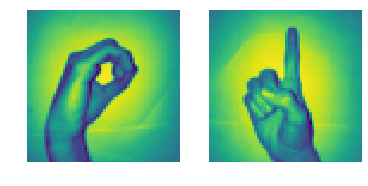

In [23]:
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(X_raw[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_raw[900].reshape(img_size, img_size))
plt.axis('off')

In [24]:
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(X_raw, Y_raw, test_size=0.15, random_state=42)
number_of_train = X_train_raw.shape[0]
number_of_test = X_test_raw.shape[0]

In [25]:
print(X_train_raw.shape)
print(X_test_raw.shape)
X_train_flatten = X_train_raw.reshape(number_of_train,X_train_raw.shape[1]*X_train_raw.shape[2])
X_test_flatten = X_test_raw.reshape(number_of_test,X_test_raw.shape[1]*X_test_raw.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

(1752, 64, 64)
(310, 64, 64)
X train flatten (1752, 4096)
X test flatten (310, 4096)


In [26]:
X_train = X_train_flatten.T
X_test = X_test_flatten.T
Y_train = Y_train_raw.T
Y_test = Y_test_raw.T
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",Y_train.shape)
print("y test: ",Y_test.shape)

x train:  (4096, 1752)
x test:  (4096, 310)
y train:  (10, 1752)
y test:  (10, 310)


In [31]:
NN = TwoLayersNeuralNet(4096, 100, 10)

In [35]:
NN.train(X_train, Y_train, n_iteration=10000, learning_rate=0.02, lambda_l2=0.001,
        momentum=0.5, n_batch=500)

Loss after iteration 0: 23.535585
Loss after iteration 100: 23.310805
Loss after iteration 200: 23.160536
Loss after iteration 300: 22.939117
Loss after iteration 400: 22.787651
Loss after iteration 500: 22.605637
Loss after iteration 600: 22.414767
Loss after iteration 700: 22.261166
Loss after iteration 800: 22.092176
Loss after iteration 900: 21.874395
Loss after iteration 1000: 21.699636
Loss after iteration 1100: 21.516431
Loss after iteration 1200: 21.339453
Loss after iteration 1300: 21.184664
Loss after iteration 1400: 20.954737
Loss after iteration 1500: 20.854184
Loss after iteration 1600: 20.667304
Loss after iteration 1700: 20.487780
Loss after iteration 1800: 20.501219
Loss after iteration 1900: 20.207968
Loss after iteration 2000: 20.012187
Loss after iteration 2100: 19.873072
Loss after iteration 2200: 19.661889
Loss after iteration 2300: 19.721855
Loss after iteration 2400: 19.375212
Loss after iteration 2500: 19.222986
Loss after iteration 2600: 19.083330
Loss after it

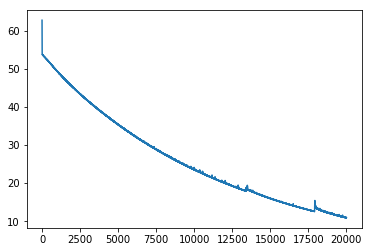

In [36]:
plt.plot(NN.losses)

In [38]:
# predict
Y_pred_test = NN.predict(X_test)
Y_pred_train = NN.predict(X_train)

print("train accuracy: {} %".format(100 - np.mean(np.sum(abs(Y_pred_train - Y_train),axis=0)/2) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.sum(abs(Y_pred_test - Y_test),axis=0)/2) * 100))

train accuracy: 91.43835616438356 %
test accuracy: 73.2258064516129 %


#### Below is old basic one

In [66]:
NN = TwoLayersNeuralNet(4096, 100, 10)

In [70]:
NN.train(X_train, Y_train, n_epoch=20000, learning_rate=0.02, n_batch=500)

Error after iteration 0: 1.101182
Error after iteration 100: 1.094840
Error after iteration 200: 1.094981
Error after iteration 300: 1.061966
Error after iteration 400: 1.017980
Error after iteration 500: 1.034033
Error after iteration 600: 1.035134
Error after iteration 700: 1.039948
Error after iteration 800: 1.003666
Error after iteration 900: 1.045204
Error after iteration 1000: 1.022525
Error after iteration 1100: 1.016106
Error after iteration 1200: 0.938636
Error after iteration 1300: 0.946592
Error after iteration 1400: 0.952456
Error after iteration 1500: 0.946019
Error after iteration 1600: 0.933021
Error after iteration 1700: 0.972602
Error after iteration 1800: 0.905326
Error after iteration 1900: 0.928921
Error after iteration 2000: 0.892441
Error after iteration 2100: 0.926284
Error after iteration 2200: 0.888265
Error after iteration 2300: 0.925844
Error after iteration 2400: 0.873165
Error after iteration 2500: 0.821163
Error after iteration 2600: 0.828787
Error after i

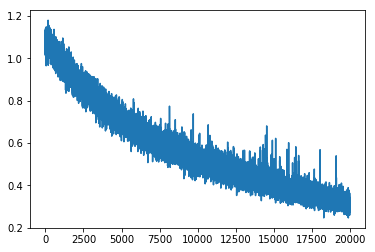

In [71]:
plt.plot(NN.errors)

In [72]:
# predict
Y_pred_test = NN.predict(X_test)
Y_pred_train = NN.predict(X_train)

print("train accuracy: {} %".format(100 - np.mean(np.sum(abs(Y_pred_train - Y_train),axis=0)/2) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.sum(abs(Y_pred_test - Y_test),axis=0)/2) * 100))

train accuracy: 91.66666666666667 %
test accuracy: 60.96774193548387 %


In [22]:
# Join a sequence of arrays along an row axis.
# from 0 to 204 is zero sign and from 205 to 410 is one sign
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


In [33]:
X_l.shape

(2062, 64, 64)

In [26]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [34]:
print(X_train.shape)
print(X_test.shape)
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

(348, 64, 64)
(62, 64, 64)
X train flatten (348, 4096)
X test flatten (62, 4096)


In [37]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


$
X_{train} = \begin{bmatrix}
x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(348)} \\
x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(348)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{4096}^{(1)} & x_{4096}^{(2)} & \cdots & x_{4096}^{(348)} \\
\end{bmatrix}
$
$
\,\,\,\,\, {\bf y}_{train} = 
\begin{bmatrix}
y^{(1)} & y^{(2)} & \cdots & y^{(348)} \\
\end{bmatrix}
$

In [39]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

$
{\bf w} = \begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_{4096} \\
\end{bmatrix}
$

Thus, we can calculate $z$ for all train data in a single matrix computation.

$
{\bf z} = {\bf w}^T X_{train} + b = 
\begin{bmatrix}
w_1 & w_2 & \cdots & w_{4096} \\
\end{bmatrix}
\begin{bmatrix}
x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(348)} \\
x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(348)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{4096}^{(1)} & x_{4096}^{(2)} & \cdots & x_{4096}^{(348)} \\
\end{bmatrix} + b
$

$
= \begin{bmatrix}
w_1x_1^{(1)} + w_2x_2^{(1)} + \cdots + w_{4096}x_{4096}^{(1)} + b &
w_1x_1^{(2)} + w_2x_2^{(2)} + \cdots + w_{4096}x_{4096}^{(2)} + b &
\cdots &
w_1x_1^{(348)} + w_2x_2^{(348)} + \cdots + w_{4096}x_{4096}^{(348)} + b
\end{bmatrix}
$

In [77]:
# check 
w,b = initialize_weights_and_bias(4096)
z = np.dot(w.T,x_train) + b
print("z shape:",z.shape)

z shape: (1, 348)


In [78]:
# calculation of z
#z = np.dot(w.T,x_train)+b
def sigmoid(z):
    y_head = 1/(1+np.exp(-z)) # with np, this calc can be applied to array.
    return y_head

In [79]:
# check
y_head = sigmoid(z)
print("y_head shape:",y_head.shape)

y_head shape: (1, 348)


In [138]:
def cost_func(y_head,y_train):
    # array*array is NOT a dot product. Just element by element multiplication.
    #     np.array([[1,2]])*np.array([[10,100]]) -> array([[  10,  200]])
    #     np.dot(np.array([[1,2]]).T,np.array([[10,100]])) -> array([[ 10, 100],[ 20, 200]])
    loss = -np.multiply(y_train,np.log(y_head))-np.multiply((1-y_train),np.log(1-y_head))
    cost = (np.sum(loss))/loss.shape[1]
    return cost

$$J = -\frac{1}{m}\sum_{i=1}^m \{ y^{(i)} log(h_w(x^{(i)})) + (1-y^{(i)})log(1-h_w(x^{(i)})) \}$$

In [139]:
# Forward propagation steps:
# find z = w.T*x+b
# y_head = sigmoid(z)
# loss(error) = loss(y,y_head)
# cost = sum(loss)
def forward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z) # probabilistic 0-1
    cost = cost_func(y_head,y_train)
    return cost 

In [140]:
# In backward propagation we will use y_head that found in forward progation
# Therefore instead of writing backward propagation method, lets combine forward propagation and backward propagation
def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    cost = cost_func(y_head,y_train)
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

$$J = -\frac{1}{m}\sum_{i=1}^m \{ y^{(i)} log(h_w(x^{(i)})) + (1-y^{(i)})log(1-h_w(x^{(i)})) \}$$

$$\frac{\partial J}{\partial w_j} = \frac{\partial J}{\partial h_w}\frac{\partial h_w}{\partial w_j}$$

$$\frac{\partial J}{\partial h_w} = \frac{\partial}{\partial h_w}\{-\frac{1}{m}\sum_{i=1}^m \{ y^{(i)} log(h_w(x^{(i)})) + (1-y^{(i)})log(1-h_w(x^{(i)})) \} \}$$

$$= -\frac{1}{m}\sum_{i=1}^m \{ \frac{y^{(i)}}{h_w(x^{(i)})} - \frac{1-y^{(i)}}{1-h_w(x^{(i)})} \}$$

Let : $v = 1 + exp(-{\bf w}^T{\bf x}-b)$, then $h_w = \frac{1}{v}$

$$\frac{\partial h_w}{\partial w_j} = \frac{\partial h_w}{\partial v}\frac{\partial v}{\partial w_j}$$

$$= - \frac{1}{v^2}\cdot -x_jexp(-{\bf w}^T{\bf x}-b) = \frac{x_jexp(-{\bf w}^T{\bf x}-b)}{(1 + exp(-{\bf w}^T{\bf x}-b))^2}$$

$$= \frac{1}{1 + exp(-{\bf w}^T{\bf x}-b)}\frac{exp(-{\bf w}^T{\bf x}-b)}{1 + exp(-{\bf w}^T{\bf x}-b)}x_j$$

$$= h_w(x^{(i)})(1-h_w(x^{(i)}))x_j$$


$$\frac{\partial J}{\partial w_j} = \frac{\partial J}{\partial h_w}\frac{\partial h_w}{\partial w_j} = -\frac{1}{m}\sum_{i=1}^m \{ \frac{y^{(i)}}{h_w(x^{(i)})} - \frac{1-y^{(i)}}{1-h_w(x^{(i)})} \} h_w(x^{(i)})(1-h_w(x^{(i)}))x_j$$

$$= -\frac{1}{m}\sum_{i=1}^m \{y^{(i)}(1-h_w(x^{(i)})) - (1-y^{(i)})h_w(x^{(i)}) \}x_j$$

$$= -\frac{1}{m}\sum_{i=1}^m \{y^{(i)} - h_w(x^{(i)}) \}x_j$$

$$= \frac{1}{m}\sum_{i=1}^m \{h_w(x^{(i)}) - y^{(i)} \}x_j$$

$$\frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=1}^m \{h_w(x^{(i)}) - y^{(i)} \}$$

Again, derivatives for all data can be calculated in a single matrix computation.

$
X_{train} = \begin{bmatrix}
x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(348)} \\
x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(348)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{4096}^{(1)} & x_{4096}^{(2)} & \cdots & x_{4096}^{(348)} \\
\end{bmatrix}
$
$
\,\,\,\,\, {\bf y}_{head} - {\bf y}_{train} = 
\begin{bmatrix}
y_h^{(1)} - y^{(1)} & y_h^{(2)} - y^{(2)} & \cdots & y_h^{(348)} - y^{(348)} \\
\end{bmatrix}
$

$
X_{train}\cdot({\bf y}_{head} - {\bf y}_{train})^T = 
\begin{bmatrix}
x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(348)} \\
x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(348)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{4096}^{(1)} & x_{4096}^{(2)} & \cdots & x_{4096}^{(348)} \\
\end{bmatrix}
\begin{bmatrix}
y_h^{(1)} - y^{(1)} \\
y_h^{(2)} - y^{(2)} \\
\vdots \\ 
y_h^{(348)} - y^{(348)} \\
\end{bmatrix}
$

$
= \begin{bmatrix}
(y_h^{(1)} - y^{(1)})x_1^{(1)} + (y_h^{(2)} - y^{(2)})x_1^{(2)} + \cdots + (y_h^{(348)} - y^{(348)})x_1^{(348)} \\
(y_h^{(1)} - y^{(1)})x_2^{(1)} + (y_h^{(2)} - y^{(2)})x_2^{(2)} + \cdots + (y_h^{(348)} - y^{(348)})x_2^{(348)} \\
\vdots \\ 
(y_h^{(1)} - y^{(1)})x_{4096}^{(1)} + (y_h^{(2)} - y^{(2)})x_{4096}^{(2)} + \cdots + (y_h^{(348)} - y^{(348)})x_{4096}^{(348)} \\
\end{bmatrix}
$

In [141]:
# Updating(learning) parameters
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iterarion times
    for i in range(number_of_iterarion):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list
#parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate = 0.009,number_of_iterarion = 200)

In [142]:
 # prediction
def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction
# predict(parameters["weight"],parameters["bias"],x_test)

Cost after iteration 0: 14.014222
Cost after iteration 10: 2.544689
Cost after iteration 20: 2.577950
Cost after iteration 30: 2.397999
Cost after iteration 40: 2.185019
Cost after iteration 50: 1.968348
Cost after iteration 60: 1.754195
Cost after iteration 70: 1.535079
Cost after iteration 80: 1.297567
Cost after iteration 90: 1.031919
Cost after iteration 100: 0.737019
Cost after iteration 110: 0.441355
Cost after iteration 120: 0.252278
Cost after iteration 130: 0.205168
Cost after iteration 140: 0.196168


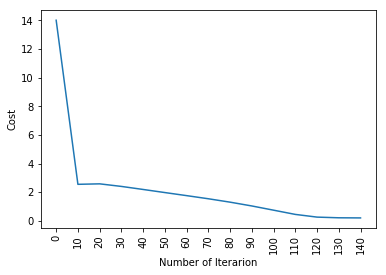

train accuracy: 92.816091954023 %
test accuracy: 93.54838709677419 %


In [143]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]  # that is 4096
    w,b = initialize_weights_and_bias(dimension)
    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 150)

## 2-Layer Neural Network

In [164]:
# intialize parameters and layer sizes
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(3,x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((3,1)),
                  "weight2": np.random.randn(y_train.shape[0],3) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

In [165]:
parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)
print('x train shape:',x_train.shape)
print('weight1 shape:',parameters['weight1'].shape)
print('bias1 shape:',parameters['bias1'].shape)
print('weight2 shape:',parameters['weight2'].shape)
print('bias2 shape:',parameters['bias2'].shape)

x train shape: (4096, 348)
weight1 shape: (3, 4096)
bias1 shape: (3, 1)
weight2 shape: (1, 3)
bias2 shape: (1, 1)


$
X_{train} = \begin{bmatrix}
x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(348)} \\
x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(348)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{4096}^{(1)} & x_{4096}^{(2)} & \cdots & x_{4096}^{(348)} \\
\end{bmatrix}
$

---

$
W^{[1]} = \begin{bmatrix}
w_1^{[z_1]} & w_2^{[z_1]} & \cdots & w_{4096}^{[z_1]} \\
w_1^{[z_2]} & w_2^{[z_2]} & \cdots & w_{4096}^{[z_2]} \\
w_1^{[z_3]} & w_2^{[z_3]} & \cdots & w_{4096}^{[z_3]} \\
\end{bmatrix}
$

$
{\bf b}^{[1]} = \begin{bmatrix}
b^{[z_1]} \\
b^{[z_2]} \\
b^{[z_3]} \\
\end{bmatrix}
$

$
W^{[2]} = \begin{bmatrix}
w_{a_1} & w_{a_2} & w_{a_3} \\
\end{bmatrix}
$

$b^{[2]}$ is a scalar

---

$Z^{[1]} = W^{[1]}X_{train} + {\bf b}^{[1]}$

$
= \begin{bmatrix}
w_1^{[z_1]} & w_2^{[z_1]} & \cdots & w_{4096}^{[z_1]} \\
w_1^{[z_2]} & w_2^{[z_2]} & \cdots & w_{4096}^{[z_2]} \\
w_1^{[z_3]} & w_2^{[z_3]} & \cdots & w_{4096}^{[z_3]} \\
\end{bmatrix}
\begin{bmatrix}
x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(348)} \\
x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(348)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{4096}^{(1)} & x_{4096}^{(2)} & \cdots & x_{4096}^{(348)} \\
\end{bmatrix} + 
\begin{bmatrix}
b^{[z_1]} \\
b^{[z_2]} \\
b^{[z_3]} \\
\end{bmatrix} = 
$

$
\begin{bmatrix}
w_1^{[z_1]}x_1^{(1)} + w_2^{[z_1]}x_2^{(1)} + ... + w_{4096}^{[z_1]}x_{4096}^{(1)} + b^{[z_1]} & 
w_1^{[z_1]}x_1^{(2)} + w_2^{[z_1]}x_2^{(2)} + ... + w_{4096}^{[z_1]}x_{4096}^{(2)} + b^{[z_1]} & 
\cdots & 
w_1^{[z_1]}x_1^{(348)} + w_2^{[z_1]}x_2^{(348)} + ... + w_{4096}^{[z_1]}x_{4096}^{(348)} + b^{[z_1]} \\
w_1^{[z_2]}x_1^{(1)} + w_2^{[z_2]}x_2^{(1)} + ... + w_{4096}^{[z_2]}x_{4096}^{(1)} + b^{[z_2]} & 
w_1^{[z_2]}x_1^{(2)} + w_2^{[z_2]}x_2^{(2)} + ... + w_{4096}^{[z_2]}x_{4096}^{(2)} + b^{[z_2]} & 
\cdots & 
w_1^{[z_2]}x_1^{(348)} + w_2^{[z_2]}x_2^{(348)} + ... + w_{4096}^{[z_2]}x_{4096}^{(348)} + b^{[z_2]} \\
w_1^{[z_3]}x_1^{(1)} + w_2^{[z_3]}x_2^{(1)} + ... + w_{4096}^{[z_3]}x_{4096}^{(1)} + b^{[z_3]} & 
w_1^{[z_3]}x_1^{(2)} + w_2^{[z_3]}x_2^{(2)} + ... + w_{4096}^{[z_3]}x_{4096}^{(2)} + b^{[z_3]} & 
\cdots & 
w_1^{[z_3]}x_1^{(348)} + w_2^{[z_3]}x_2^{(348)} + ... + w_{4096}^{[z_3]}x_{4096}^{(348)} + b^{[z_3]} \\
\end{bmatrix}
$

$
= \begin{bmatrix}
z_1^{(1)} & z_1^{(2)} & \cdots & z_1^{(348)} \\
z_2^{(1)} & z_2^{(2)} & \cdots & z_2^{(348)} \\
z_3^{(1)} & z_3^{(2)} & \cdots & z_3^{(348)} \\
\end{bmatrix}
$

In [166]:
def forward_propagation_NN(x_train, parameters):

    Z1 = np.dot(parameters["weight1"],x_train) +parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [167]:
A2, cache = forward_propagation_NN(x_train, parameters)
print('Z1 shape:',cache['Z1'].shape)
print('A1 shape:',cache['A1'].shape)
print('Z2 shape:',cache['Z2'].shape)
print('A2 shape:',cache['A2'].shape)

Z1 shape: (3, 348)
A1 shape: (3, 348)
Z2 shape: (1, 348)
A2 shape: (1, 348)


$
A^{[1]}= \begin{bmatrix}
tanh(z_1^{(1)}) & tanh(z_1^{(2)}) & \cdots & tanh(z_1^{(348)}) \\
tanh(z_2^{(1)}) & tanh(z_2^{(2)}) & \cdots & tanh(z_2^{(348)}) \\
tanh(z_3^{(1)}) & tanh(z_3^{(2)}) & \cdots & tanh(z_3^{(348)}) \\
\end{bmatrix} = 
$
$
\begin{bmatrix}
a_1^{(1)} & a_1^{(2)} & \cdots & a_1^{(348)} \\
a_2^{(1)} & a_2^{(2)} & \cdots & a_2^{(348)} \\
a_3^{(1)} & a_3^{(2)} & \cdots & a_3^{(348)} \\
\end{bmatrix}
$

$Z^{[2]} = W^{[2]}A^{[1]}+b^{[2]}$

$
= \begin{bmatrix}
w_{a_1} & w_{a_2} & w_{a_3} \\
\end{bmatrix}
\begin{bmatrix}
a_1^{(1)} & a_1^{(2)} & \cdots & a_1^{(348)} \\
a_2^{(1)} & a_2^{(2)} & \cdots & a_2^{(348)} \\
a_3^{(1)} & a_3^{(2)} & \cdots & a_3^{(348)} \\
\end{bmatrix} +b^{[2]}
$

$
= \begin{bmatrix}
w_{a_1}a_1^{(1)} + w_{a_2}a_2^{(1)} + w_{a_3}a_3^{(1)} + b^{[2]} & 
w_{a_1}a_1^{(2)} + w_{a_2}a_2^{(2)} + w_{a_3}a_3^{(2)} + b^{[2]} & 
\cdots & 
w_{a_1}a_1^{(348)} + w_{a_2}a_2^{(348)} + w_{a_3}a_3^{(348)} + b^{[2]} \\
\end{bmatrix}
$

$
= \begin{bmatrix}
z_4^{(1)} & z_4^{(2)} & \cdots &z_4^{(348)} \\
\end{bmatrix}
$

$
A^{[2]}= \begin{bmatrix}
sigmoid(z_4^{(1)}) & sigmoid(z_4^{(2)}) & \cdots & sigmoid(z_4^{(348)}) \\
\end{bmatrix} = 
\begin{bmatrix}
a_4^{(1)} & a_4^{(2)} & \cdots & a_4^{(348)} \\
\end{bmatrix}
$

In [168]:
# Backward Propagation
def backward_propagation_NN(parameters, cache, X, Y):

    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    #dZ1 = np.divide(np.dot(parameters["weight2"].T,dZ2), np.power(np.cosh(cache["Z1"]),2))
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [169]:
# update parameters
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

In [170]:
# prediction
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Cost after iteration 0: 0.698011
Cost after iteration 100: 0.694058
Cost after iteration 200: 0.693347
Cost after iteration 300: 0.693182
Cost after iteration 400: 0.693129
Cost after iteration 500: 0.693102
Cost after iteration 600: 0.693081
Cost after iteration 700: 0.693055
Cost after iteration 800: 0.693003
Cost after iteration 900: 0.692833
Cost after iteration 1000: 0.692102
Cost after iteration 1100: 0.689620
Cost after iteration 1200: 0.679219
Cost after iteration 1300: 0.645797
Cost after iteration 1400: 0.582445
Cost after iteration 1500: 0.501149
Cost after iteration 1600: 0.421289
Cost after iteration 1700: 0.425369
Cost after iteration 1800: 0.327437
Cost after iteration 1900: 0.284265
Cost after iteration 2000: 0.248258
Cost after iteration 2100: 0.215195
Cost after iteration 2200: 0.184572
Cost after iteration 2300: 0.162470
Cost after iteration 2400: 0.146102


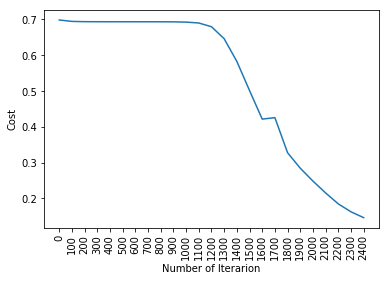

train accuracy: 99.42528735632185 %
test accuracy: 93.54838709677419 %


In [171]:
# 2 - Layer neural network
def two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)

    for i in range(0, num_iterations):
         # forward propagation
        A2, cache = forward_propagation_NN(x_train,parameters)
        # compute cost
        cost = cost_func(A2, y_train)
        #cost = compute_cost_NN(A2, y_train, parameters)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters

parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations=2500)

In [108]:
parameters['bias1']

array([[0.],
       [0.],
       [0.]])

In [111]:
parameters['weight1'].shape

(3, 4096)

In [120]:
a = np.array([[1,2,3],[4,5,6]])

In [121]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [128]:
b = np.array([[10,100]])

In [130]:
b.T

array([[ 10],
       [100]])

In [131]:
a + b.T

array([[ 11,  12,  13],
       [104, 105, 106]])

In [154]:
np.divide(np.array([[10,20,30],[100,200,300]]),np.array([[1,2,3],[1,2,3]]))

array([[ 10.,  10.,  10.],
       [100., 100., 100.]])

In [156]:
np.power(np.array([[1,2,3],[4,5,6]]),2)

array([[ 1,  4,  9],
       [16, 25, 36]])